In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image, ImageOps 


### Architecture

In [2]:
width = 32
height = 32
depth = 3
latent_space_dim = 16

inputs = Input(shape = (width, height, depth))

x = Conv2D(8, (3, 3), strides=2, padding="same")(inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

In [3]:
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_space_dim, name="latent")(x)

latentInputs = Input(shape=(latent_space_dim,))
y = Dense(np.prod(volumeSize[1:]))(latentInputs)
y = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(y)

y = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization(axis=-1)(y) 

y = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization(axis=-1)(y)

y = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization(axis=-1)(y)

y = Conv2DTranspose(8, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization(axis=-1)(y)

y = Conv2DTranspose(depth, (3, 3), padding="same")(y)
outputs = Activation("sigmoid", name="decoded")(y)

#encoder = Model(input = x, outupt = latent)
encoder = Model(inputs, latent, name="encoder")
decoder = Model(latentInputs, outputs, name="decoder")

autoencoder = Model(inputs=inputs, outputs=decoder(encoder(inputs)))

### Load dataset

In [4]:
import os
import cv2
import random

In [5]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch = image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)

        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)
        noisy = image + image * gauss
        return noisy

In [6]:
def img_paths(path):
    imgs_path = [os.path.join(path, i) for i in os.listdir(path)]
    imgs_path = [os.path.join(sub_dir, img) for sub_dir in imgs_path for img in os.listdir(sub_dir)]
    return imgs_path

def load_dataset(imgs_path):
    dataset = [np.asarray(Image.open(img_path)) for img_path in imgs_path]
    dataset = np.asarray(dataset)
    return np.take(dataset, np.random.permutation(dataset.shape[0]), axis=0, out=dataset)

def resize_img(img, width, height):
    img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
    noise = random.choice(["gauss","s&p","speckle"])
    return noisy(noise,img)
    
def resize_dataset(dataset, width, height):
    return np.asarray([resize_img(img, width, height) for img in dataset])

In [7]:
imagePathTest = img_paths('dataset/Teste')
imagePathTrain = img_paths('dataset/Traine')

testDataset = load_dataset(imagePathTest)
trainDataset = load_dataset(imagePathTrain)

test = resize_dataset(testDataset,32,32)/255.0
train = resize_dataset(trainDataset,32,32)/255.0

c:\users\tiagoasfasf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\users\tiagoasfasf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [8]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
#(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
#autoencoder = ConvAutoencoder.build(28, 28, 1)
#autoencoder = autoencoderModel(28,28,1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [9]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 8)         224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 16)          64  

In [10]:
EPOCHS = 25
BATCH_SIZE = 32

# train the convolutional autoencoder
H = autoencoder.fit(
	train, train,
	validation_data=(test, test),
	epochs=EPOCHS,
	batch_size=BATCH_SIZE)


Train on 67692 samples, validate on 22688 samples
Epoch 1/25
67692/67692 [==============================] - 37s 548us/sample - loss: 0.1711 - val_loss: 0.1678
Epoch 2/25
67692/67692 [==============================] - 29s 429us/sample - loss: 0.1640 - val_loss: 0.1671
Epoch 3/25
67692/67692 [==============================] - 29s 424us/sample - loss: 0.1632 - val_loss: 0.1663
Epoch 4/25
67692/67692 [==============================] - 29s 423us/sample - loss: 0.1625 - val_loss: 0.1662
Epoch 5/25
67692/67692 [==============================] - 29s 422us/sample - loss: 0.1621 - val_loss: 0.1657
Epoch 6/25
67692/67692 [==============================] - 29s 422us/sample - loss: 0.1618 - val_loss: 0.1660
Epoch 7/25
67692/67692 [==============================] - 29s 429us/sample - loss: 0.1617 - val_loss: 0.1658
Epoch 8/25
67692/67692 [==============================] - 29s 427us/sample - loss: 0.1615 - val_loss: 0.1653
Epoch 9/25
67692/67692 [==============================] - 29s 430us/sample - l

In [11]:
encoder.save('encoder{}.h5'.format(latent_space_dim))
decoder.save('decoder{}.h5'.format(latent_space_dim))

autoencoder.save('autoencoder{}.h5'.format(latent_space_dim))

recon = autoencoder.predict(test)

In [12]:
ls_dim = 16

autoencoder = tf.keras.models.load_model('autoencoder{}.h5'.format(ls_dim))
encoder = tf.keras.models.load_model('encoder{}.h5'.format(ls_dim))
decoder = tf.keras.models.load_model('decoder{}.h5'.format(ls_dim))


In [13]:
recon = autoencoder.predict(test)

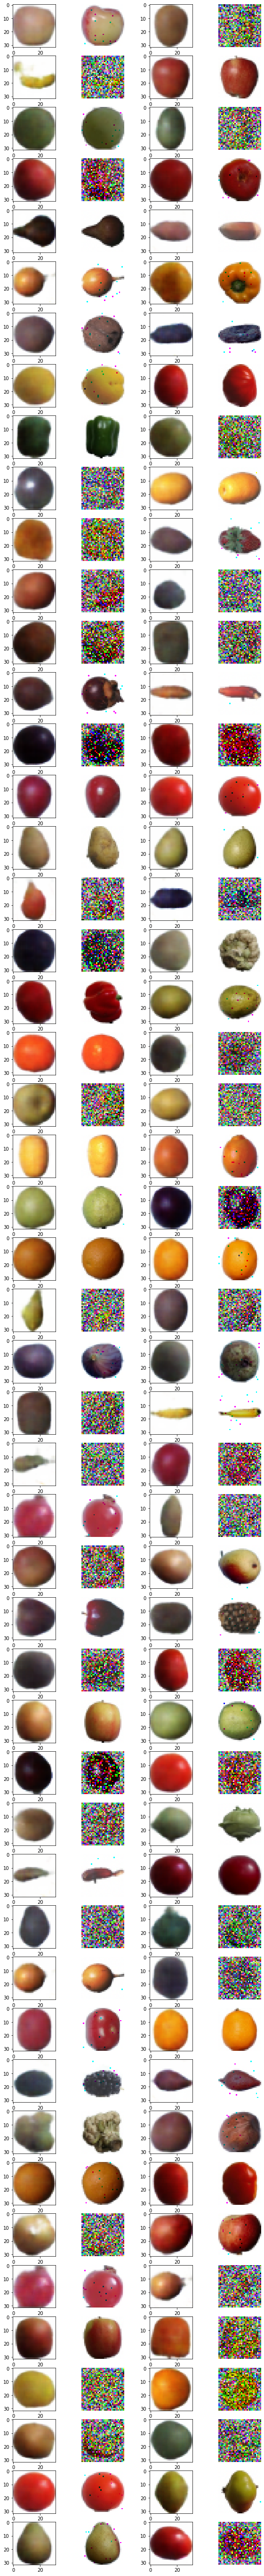

In [14]:
def show_batch(set1, set2, count):
  columns = 4
  rows = count*2 / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.imshow(set1[n])
      ax = plt.subplot(rows, columns, n*2+2)
      plt.imshow(set2[n])

      plt.axis('off')
        
testXImage = (test * 255).astype("uint8").squeeze() 
reconImage = (recon * 255).astype("uint8").squeeze()
show_batch(reconImage, testXImage, 100)